In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')
data.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [3]:
columns_to_use = [
    'Make',
    'Model',
    'Year',
    'Engine HP',
    'Engine Cylinders',
    'Transmission Type',
    'Vehicle Style',
    'highway MPG',
    'city mpg',
    'MSRP'
    ]

# Data preparation

* Keep only the columns above

* Lowercase the column names and replace spaces with underscores

* Fill the missing values with 0

* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average

* Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [4]:
data = data[columns_to_use]
data.columns = data.columns.str.replace(' ', '_').str.lower()
data.fillna(0.0, inplace=True)
mean_price = data['msrp'].mean()
data.loc[:, 'above_average'] = (data['msrp'] > mean_price).astype(int)
data.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0


In [5]:
train, val_test = train_test_split(data, test_size=0.4, random_state=1)
val, test = train_test_split(val_test, test_size=0.5, random_state=1)

# Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that.

* For each numerical variable, use it as score and compute AUC with the above_average variable.

* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.



In [6]:
numerical_features = [
    'year', 
    'engine_hp', 
    'engine_cylinders',
    'highway_mpg', 
    'city_mpg'
    ]

categorical_features = [
    'make', 
    'model', 
    'transmission_type', 
    'vehicle_style'
    ]

In [7]:
print('AUC with the above_average variable')
for numerical_feature in numerical_features:
    auc_score = roc_auc_score(train['above_average'], train[numerical_feature])
    print(f'{numerical_feature}: {auc_score: .3f}')

AUC with the above_average variable
year:  0.694
engine_hp:  0.916
engine_cylinders:  0.768
highway_mpg:  0.367
city_mpg:  0.328


In [8]:
features_to_invert = ['highway_mpg', 'city_mpg']
train[features_to_invert] = -train[features_to_invert]
val[features_to_invert] = -val[features_to_invert]
test[features_to_invert] = -test[features_to_invert]

In [9]:
for numerical_feature in numerical_features:
    auc_score = roc_auc_score(train['above_average'], train[numerical_feature])
    print(f'{numerical_feature}: {auc_score: .3f}')

year:  0.694
engine_hp:  0.916
engine_cylinders:  0.768
highway_mpg:  0.633
city_mpg:  0.672


# Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [10]:
categorical_dict = train[categorical_features].to_dict(orient="records")
dv = DictVectorizer(sparse = False)
dv.fit(categorical_dict)

categorical_data_tr = dv.transform(categorical_dict)
numerical_data_tr = np.array(train[numerical_features])
X_tr, y_tr = np.concatenate((numerical_data_tr, categorical_data_tr), axis=1), train['above_average']

# doing one-hot encoding separatly we want the same number of columns; so we don't call fit again
categorical_dict_val = val[categorical_features].to_dict(orient="records")
categorical_data_val = dv.transform(categorical_dict_val)
numerical_data_val = np.array(val[numerical_features])
X_val, y_val = np.concatenate((numerical_data_val, categorical_data_val), axis=1), val['above_average']

categorical_dict_test = test[categorical_features].to_dict(orient="records")
categorical_data_test = dv.transform(categorical_dict_test)
numerical_data_test = np.array(test[numerical_features])
X_test, y_test = np.concatenate((numerical_data_test, categorical_data_test), axis=1), test['above_average']

X_tr.shape, X_val.shape, X_test.shape

((7148, 954), (2383, 954), (2383, 954))

In [11]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_tr, y_tr)
pred_proba = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, pred_proba)

0.980159557687269

# Question 3: Precision and Recall
Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

In [12]:
thresholds = np.linspace(0.0, 1.0, num=101)
precision = []
recall = []
f1_scores = []
fpr = []

for t in thresholds[:-1]: 

    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (pred_proba >= t)
    predict_negative = (pred_proba < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2*p*r / (p + r)

    fall_out = fp / (fp + tn)

    precision.append(p)
    recall.append(r)
    f1_scores.append(f1)
    fpr.append(fall_out) # false positive rates for different t

In [13]:
# at which threshold precision and recall curves intersect
index_intersect = np.argmin(np.abs(np.array(precision) - np.array(recall)))
precision[index_intersect], recall[index_intersect], thresholds[index_intersect ]

(0.8790697674418605, 0.8777089783281734, 0.47000000000000003)

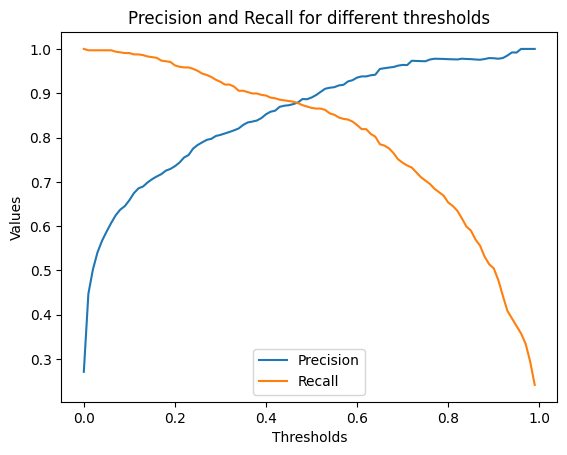

In [14]:
precision_plot = plt.plot(thresholds[:-1], precision, label='Precision')
recall_plot = plt.plot(thresholds[:-1], recall, label='Recall')

plt.legend()
plt.xlabel('Thresholds')
plt.ylabel('Values')
plt.title('Precision and Recall for different thresholds')
plt.show()

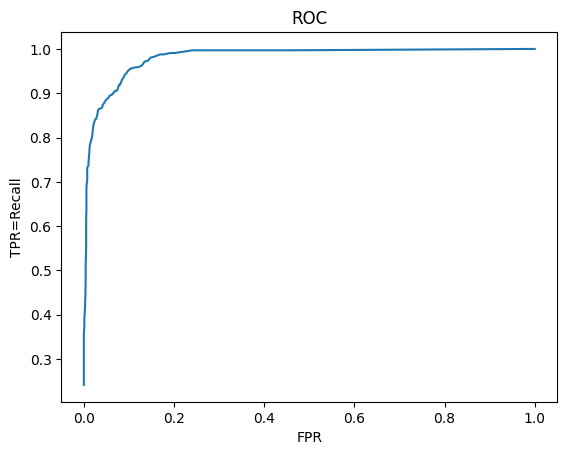

In [15]:
precision_plot = plt.plot(fpr, recall) # true positive rate = recall = sensitivity

plt.xlabel('FPR')
plt.ylabel('TPR=Recall')
plt.title('ROC')
plt.show()

In [16]:
# increasing the number of threshold values, we can achieve that these values are less distinct from each other
roc_auc_score(y_val, pred_proba), auc(fpr, recall) 

(0.980159557687269, 0.9808872098971395)

# Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [17]:
index_max_f1 = np.argmax(f1_scores)
index_max_f1, thresholds[index_max_f1]

(53, 0.53)

# Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

Iterate over different folds of df_full_train

Split the data into train and validation

Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

Use AUC to evaluate the model on validation

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
roc_aucs = []
for i, (train_index, test_index) in enumerate(kf.split(X_tr)):
    X_train, y_train, X_valid, y_valid = X_tr[train_index], np.array(y_tr)[train_index], X_tr[test_index], np.array(y_tr)[test_index]
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    pred_proba = model.predict_proba(X_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, pred_proba)
    roc_aucs.append(roc_auc)
    print(f'fold {i+1}, roc_auc: {roc_auc}')

print(f'standard devidation of the scores across different folds: {np.std(np.array(roc_aucs)): .3f}')

fold 1, roc_auc: 0.979493670886076
fold 2, roc_auc: 0.9793203883495146
fold 3, roc_auc: 0.9674984355444306
fold 4, roc_auc: 0.9783087856627871
fold 5, roc_auc: 0.9801718566744059
standard devidation of the scores across different folds:  0.005


# Question 6: Hyperparemeter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.01, 0.1, 0.5, 10]

Initialize KFold with the same parameters as previously

Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)

Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [19]:
for C in [0.01, 0.1, 0.5, 10]:
    print(f'C = {C}')
    roc_aucs = []
    for i, (train_index, test_index) in enumerate(kf.split(X_tr)):
        X_train, y_train, X_valid, y_valid = X_tr[train_index], np.array(y_tr)[train_index], X_tr[test_index], np.array(y_tr)[test_index]
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        pred_proba = model.predict_proba(X_valid)[:, 1]
        roc_auc = roc_auc_score(y_valid, pred_proba)
        roc_aucs.append(roc_auc)
        print(f'fold {i+1}, roc_auc: {roc_auc: .3f}')

    print(f'standard devidation of the scores across different folds: {np.std(np.array(roc_aucs)): .3f}')
    print(f'mean of the scores across different folds: {np.mean(np.array(roc_aucs)): .3f}')
    print('-------------------------------------------------')

C = 0.01
fold 1, roc_auc:  0.952
fold 2, roc_auc:  0.945
fold 3, roc_auc:  0.941
fold 4, roc_auc:  0.954
fold 5, roc_auc:  0.952
standard devidation of the scores across different folds:  0.005
mean of the scores across different folds:  0.949
-------------------------------------------------
C = 0.1
fold 1, roc_auc:  0.970
fold 2, roc_auc:  0.971
fold 3, roc_auc:  0.964
fold 4, roc_auc:  0.973
fold 5, roc_auc:  0.971
standard devidation of the scores across different folds:  0.003
mean of the scores across different folds:  0.970
-------------------------------------------------
C = 0.5
fold 1, roc_auc:  0.976
fold 2, roc_auc:  0.979
fold 3, roc_auc:  0.972
fold 4, roc_auc:  0.978
fold 5, roc_auc:  0.977
standard devidation of the scores across different folds:  0.002
mean of the scores across different folds:  0.976
-------------------------------------------------
C = 10
fold 1, roc_auc:  0.977
fold 2, roc_auc:  0.979
fold 3, roc_auc:  0.980
fold 4, roc_auc:  0.986
fold 5, roc_auc: 